# Posterior decoding of simulated data

## Load packages and define model

In [2]:
import sys
from trails.optimizer import trans_emiss_calc
from trails.cutpoints import cutpoints_ABC, cutpoints_AB
import numpy as np
from trails.optimizer import forward_loglik, post_prob_wrapper, viterbi
import pandas as pd
import time
import re
import msprime
%load_ext rpy2.ipython

/Users/au595587/opt/miniconda3/envs/trails_plot/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
ILS = 32
seed = 333

t_A = 200000
t_B = 200000
t_C = 200000
t_1 = max([t_A, t_B, t_C])
N_AB = 80000
t_2 = -N_AB*np.log(3/2*ILS/100)
N_ABC = 70000
t_3 = t_1*5
r = 0.5e-8
mu = 1.5e-8
n_int_AB = 5
n_int_ABC_2 = 7
n_int_ABC_1 = 4

n_sites = 200000

t_2

58717.534006416034

In [4]:
2/3*np.exp(-t_2/N_AB)

0.31999999999999995

## Modified cutpoints (second coalescent)

This section deals with computing the posterior decoding using the original cutpoints in TRAILS. This means that the time between the first and the second coalescent will be divided into quantiles of an exponential with rate 1 (measured in units of $N_\text{AB}$), while the time before the first coalescent event will be divided into an exponential with rate 1 (measured in units of $N_\text{ABC}$). 

TRAILS is not restricted to this cutpoint scheme, and the user can speficy the desired intervals. Since the second coalescent will follow a mixture between an exponential with rate of 1 (for the V0 states) and a convolution of two exponentials with rates 3 and 1 (for the deep coalescent states), we can retrieve the quantiles of a phase-type distribution representing this mixture.

In [5]:
t_out = t_1+t_2+t_3+2*N_ABC

N_ref = N_ABC

coal_ABC = N_ref/N_ABC
coal_AB = N_ref/N_AB
t_upper = t_3-cutpoints_ABC(n_int_ABC_2, coal_ABC)[-2]*N_ref
t_AB = t_2/N_ref

cut_AB = t_1+cutpoints_AB(n_int_AB, t_AB, coal_AB)*N_ref
# cut_ABC = t_1+t_2+cutpoints_ABC(n_int_ABC_2, coal_ABC)*N_ref

(2/3)*(np.exp(-t_2/(N_AB)))

0.31999999999999995

R[write to console]: 
Attaching package: ‘PhaseTypeR’


R[write to console]: The following object is masked from ‘package:stats’:

    var




── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


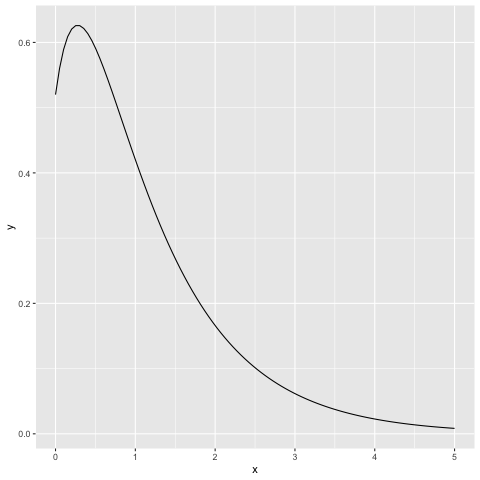

In [6]:
%%R -i t_2 -i N_AB -i n_int_ABC_2 -o quant

library(PhaseTypeR)
library(tidyverse)

subint_mat <- matrix(
    c(
        c(-1, 0, 0),
        c(0, -3, 3),
        c(0, 0, -1)
    ),
    nrow = 3,
    byrow = T
)
init_probs <- c(1-exp(-t_2/N_AB), exp(-t_2/N_AB), 0)
ph_obj <- PH(subint_mat, init_probs)

quant <- qPH(seq(0, 1, length.out = n_int_ABC_2+1), ph_obj)
quant <- c(quant[1:(length(quant)-1)], Inf)

x <- seq(0, 5, length.out = 100)
y <- dPH(x, ph_obj)
ggplot() +
    geom_line(aes(x, y))

In [7]:
t_1+t_2+cutpoints_ABC(n_int_ABC_2, coal_ABC)*N_ref

array([258717.53400642, 269508.08159432, 282270.5905699 , 297890.6391619 ,
       318028.38423352, 346410.94180109, 394931.24444029,             inf])

In [8]:
cut_ABC = t_1+t_2+quant*N_ABC
cut_ABC

array([258717.53400642, 275680.38719023, 291866.09530467, 309719.93419909,
       331364.74879218, 360730.39159387, 409808.60128951,             inf])

In [8]:
transitions, emissions, starting, hidden_states, observed_states = trans_emiss_calc(
    t_A*mu, t_B*mu, t_C*mu, t_2*mu, t_upper*mu, t_out*mu, 
    N_AB*mu, N_ABC*mu, r/mu, n_int_AB, n_int_ABC_2,
    cut_AB = 'standard', cut_ABC = quant
)

2023-11-01 15:44:35,918	INFO worker.py:1625 -- Started a local Ray instance.
/Users/au595587/opt/miniconda3/envs/trails_plot/lib/python3.9/site-packages/trails/get_emission_prob_mat.py:632: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if cut_ABC == 'standard':


In [9]:
dct_hid = {v: k for k, v in hidden_states.items()}
dct = {v: k for k, v in observed_states.items()}

In [47]:
seed = 10

for seed in range(13, 30):

    print(seed)

    ####################### Add demography #######################

    n_sites = 200_000

    demography = msprime.Demography()
    demography.add_population(name="A", initial_size=N_AB, default_sampling_time=t_1-t_A)
    demography.add_population(name="B", initial_size=N_AB, default_sampling_time=t_1-t_B)
    demography.add_population(name="C", initial_size=N_AB, default_sampling_time=t_1-t_C)
    demography.add_population(name="D", initial_size=N_AB, default_sampling_time=t_1-t_1)
    demography.add_population(name="AB", initial_size=N_AB)
    demography.add_population(name="ABC", initial_size=N_ABC)
    demography.add_population(name="ABCD", initial_size=N_ABC)
    demography.add_population_split(time=t_1, derived=["A", "B"], ancestral="AB")
    demography.add_population_split(time=t_1+t_2, derived=["AB", "C"], ancestral="ABC")
    demography.add_population_split(time=t_1+t_2+t_3, derived=["ABC", "D"], ancestral="ABCD")

    ts = msprime.sim_ancestry(
        {"A": 1, "B": 1, "C": 1,
        "D": 1
        },
        demography=demography,
        recombination_rate=r,
        sequence_length=n_sites,
        ploidy=1,
        random_seed=seed
    )

    #### Add mutations

    mutated_ts = msprime.sim_mutations(ts, rate=mu, random_seed=seed)

    nochange_lst = [dct['AAAA'], dct['CCCC'], dct['TTTT'], dct['GGGG']]
    np.random.seed(seed) ; sim_genome = np.random.choice(nochange_lst, n_sites)

    mut_lst = []
    mut_loc = []
    for variant in mutated_ts.variants():
        mut_loc.append(variant.site.position)
        mut_lst.append(''.join([variant.alleles[i] for i in variant.genotypes]))

    for i in range(len(mut_loc)):
        sim_genome[int(mut_loc[i])] = dct[mut_lst[i]]

    post = post_prob_wrapper(transitions, emissions, starting, [sim_genome])[0]


    hidden_matrix = np.random.randint(max([n_int_AB, n_int_ABC_2]), size=(len(dct_hid), 4))
    hidden_matrix[:,0] = list(range(len(dct_hid)))
    hidden_matrix[:,1] = [i[0] for i in dct_hid.keys()]
    hidden_matrix[:,2] = [i[1] for i in dct_hid.keys()]
    hidden_matrix[:,3] = [i[2] for i in dct_hid.keys()]


    left_lst = []
    right_lst = []
    tree_state = []
    t_AB_vec = []
    t_ABC_vec = []
    for t in ts.trees():
        # Append start coordinate
        left_lst.append(t.interval.left)
        # Append end coordinate
        right_lst.append(t.interval.right-1)
        # Get all non-zero coalescent times
        ntimes = [ts.nodes()[n].time for n in t.nodes() if ts.nodes()[n].time not in [0, t_1-t_A, t_1-t_B, t_1-t_C]]
        ntimes = sorted(ntimes)
        # Get time of the first event
        mint = ntimes[0]
        mint2 = ntimes[1]
        # Find topology
        find_re = re.findall("n\d,n\d", t.as_newick(include_branch_lengths=False))[0]
        # Sort species within topology
        find_re = sorted(find_re.split(','))
        # If V0 or V1
        if find_re == ['n0', 'n1']:
            # If the time of the first coalescent is larger than the deepest speciation event
            if mint>=(t_1+t_2):
                state = (1, (mint>cut_ABC).sum()-1, (mint2>cut_ABC).sum()-1)
                # Append V1 state
            else:
                state = (0, (mint>cut_AB).sum()-1, (mint2>cut_ABC).sum()-1)
                # Append V0 state
        # If V2
        elif find_re == ['n0', 'n2']:
            state = (2, (mint>cut_ABC).sum()-1, (mint2>cut_ABC).sum()-1)
        # If V3
        elif find_re == ['n1', 'n2']:
            state = (3, (mint>cut_ABC).sum()-1, (mint2>cut_ABC).sum()-1)
        else:
            state = (4, (mint>cut_ABC).sum()-1, (mint2>cut_ABC).sum()-1)
        tree_state.append(state)
        t_AB_vec.append(mint)
        t_ABC_vec.append(mint2)


    tree_matrix = np.random.randint(max(left_lst), size=(len(left_lst), 3))
    tree_matrix[:,0] = left_lst
    tree_matrix[:,1] = right_lst
    tree_matrix[:,2] = [dct_hid[i] for i in tree_state]

    pd.DataFrame(tree_matrix, columns=['start', 'end', 'name']).to_csv(f'../results/tmp/tree_matrix_{seed}.csv', index = False)
    pd.DataFrame(post, columns = [f'V{j}' for j in range(0, 119)]).to_csv(f'../results/tmp/post_{seed}.csv', index = False)


13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [43]:
pd.DataFrame(hidden_matrix, columns=['name', 'topology', 'int_1', 'int_2']).to_csv('hidden_matrix.csv', index = False)

In [48]:
%%R 

library(tidyverse)

hid_tab <- read_csv('hidden_matrix.csv', show_col_types = FALSE)

write_csv(hid_tab, paste0('../results/replicates/hid_tab.csv'))

for (seed in 13:29) {
    print(seed)
    tree_tab <- read_csv(paste0('../results/tmp/tree_matrix_', seed, '.csv'), show_col_types = FALSE) %>%
        mutate(
            gr = ifelse(lag(name) != name, 1, 0) %>% coalesce(0),
            gr = cumsum(gr) + 1
        ) %>% 
        group_by(gr, name) %>%
        summarize(start = min(start), end = max(end), .groups = 'drop') %>%
        left_join(hid_tab, by = 'name')
        
    write_csv(tree_tab, paste0('../results/replicates/tree_tab_', seed, '.csv'))

    post_tab <- read_csv(paste0('../results/tmp/post_', seed, '.csv'), show_col_types = FALSE) %>%
        mutate(pos = 0:(n()-1)) %>%
        pivot_longer(-pos) %>%
        mutate(name = as.integer(str_remove_all(name, 'V'))-1) %>%
        left_join(hid_tab, by = 'name')
        
    write_csv(post_tab, paste0('../results/replicates/post_tab_', seed, '.csv'))

}
    


[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29


In [33]:
%%R -i n_sites

library(tidyverse)

# int_2_tab_true <- tibble()
# int_2_tab_post2 <- tibble()
# for (i in 10:29) {
#     print(i)
#     int_2_tab_post2 <- bind_rows(int_2_tab_post2, 
#         read_csv(paste0('../results/replicates/post_tab_', i,'.csv'), show_col_types = FALSE) %>% 
#         mutate(nsim = i) %>%
#         group_by(nsim, pos, int_2) %>%
#         summarize(prob = sum(value), .groups = 'drop') %>%
#         group_by(nsim, pos) %>%
#         filter(prob == max(prob)) %>%
#         group_by(nsim, int_2) %>%
#         summarize(
#             suma = n()/n_sites,
#             .groups = 'drop'
#         ) %>%
#         arrange(nsim, desc(int_2)) %>%
#         mutate(Type = 'Posterior max'))
#     int_2_tab_true <- bind_rows(int_2_tab_true, 
#         read_csv(paste0('../results/replicates/tree_tab_', i,'.csv'), show_col_types = FALSE) %>% 
#         mutate(nsim = i) %>%
#         group_by(nsim, int_2) %>%
#         summarize(
#             suma = sum(end-start)/n_sites, .groups = 'drop'
#         ) %>%
#         arrange(nsim, desc(int_2)) %>%
#         mutate(Type = 'Empirical'))
# }

# int_2_tab_post3 <- tibble()
# for (i in 10:15) {
#     print(i)
#     int_2_tab_post3 <- bind_rows(int_2_tab_post3, 
#         read_csv(paste0('../results/replicates/post_tab_', i,'.csv'), show_col_types = FALSE) %>% 
#         mutate(nsim = i) %>%
#         group_by(nsim, pos, int_2) %>%
#         summarize(prob = sum(value), .groups = 'drop') %>%
#         group_by(nsim, int_2) %>%
#         summarize(
#             suma = median(prob),
#             .groups = 'drop'
#         ) %>%
#         arrange(nsim, desc(int_2)) %>%
#         mutate(Type = 'Posterior max'))
# }

# int_2_tab_post4 <- tibble()
# for (i in 10:29) {
#     print(i)
#     int_2_tab_post4 <- bind_rows(int_2_tab_post4, 
#         read_csv(paste0('../results/replicates/post_tab_', i,'.csv'), show_col_types = FALSE) %>% 
#         mutate(nsim = i) %>%
#         group_by(nsim, pos, int_2) %>%
#         summarize(prob = sum(value), .groups = 'drop') %>%
#         group_by(nsim, int_2) %>%
#         summarize(
#             suma = mean(prob),
#             .groups = 'drop'
#         ) %>%
#         arrange(nsim, desc(int_2)) %>%
#         mutate(Type = 'Posterior max'))
# }

# write_csv(int_2_tab_post4, 'int_2_tab_post4.csv')
# write_csv(int_2_tab_post3, 'int_2_tab_post3.csv')

# write_csv(int_2_tab_true, 'int_2_tab_true.csv')
# write_csv(int_2_tab_post2, 'int_2_tab_post2.csv')

int_2_tab_true <- read_csv('int_2_tab_true.csv')
int_2_tab_post2 <- read_csv('int_2_tab_post4.csv')

Rows: 140 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Type
dbl (3): nsim, int_2, suma

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 160 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Type
dbl (3): nsim, int_2, suma

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [31]:
%%R -i n_int_ABC_2 -i n_sites

n_int_ABC = n_int_ABC_2

int_2_tab_theo <- tibble(
    int_2 = 0:(n_int_ABC-1),
    suma = 1/n_int_ABC,
    Type = 'Theoretical'
)

# write_csv(int_2_tab_true, 'int_2_tab_true.csv')
# write_csv(int_2_tab_post2, 'int_2_tab_post2.csv')

summary_table <- bind_rows(
    int_2_tab_true, 
    int_2_tab_post2 
    ) %>% 
    mutate( Type = ifelse(Type == 'Posterior max', 'Mean posterior\nprobability', Type)) %>%
    group_by(int_2, Type) %>%
    summarize(m = mean(suma))


`summarise()` has grouped output by 'int_2'. You can override using the
`.groups` argument.


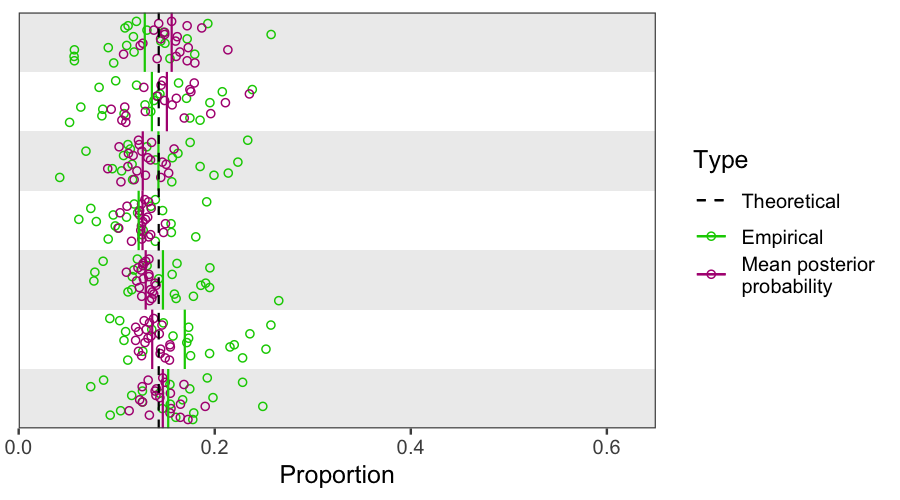

In [32]:
%%R -w 900 -h 500 -r 150 

n_int_ABC_2

library(ggthemes)

plot_post_binned <- bind_rows(
    # int_2_tab_post, 
    int_2_tab_true, 
    int_2_tab_post2, 
    # int_2_tab_theo
    ) %>%
    mutate(Type = ifelse(Type == 'Posterior max', 'Mean posterior\nprobability', Type),
        Type = factor(Type, (c('Empirical', 'Mean posterior\nprobability')))
        ) %>% 
    ggplot() +
    # geom_vline(aes(xintercept = x), data = tibble(x = 0:n_int_ABC), color = 'grey80') +
    geom_rect(aes(xmin = xmin, xmax = xmax, ymin = -Inf, ymax = Inf), 
              data = tibble(xmin = seq(0, n_int_ABC, 2), xmax = seq(1, n_int_ABC, 2)), fill = 'grey93') +
    # geom_col(aes(int_2, suma, fill = Type), position = 'dodge', color = 'black', width = 0.7) +
    geom_point(aes(int_2+((nsim-10)/20-0)/(0.95-0)*(0.85-0.15)+0.15, suma, color = Type), shape = 21) +
    geom_segment(aes(x = int_2, xend = int_2+1, y= m, yend = m, color = Type), data = summary_table) +
    geom_hline(aes(yintercept = 1/n_int_ABC, color = 'Theoretical'), linetype = 2) +
    # geom_segment(aes(x = int_2+(Type=='Empirical')*1/3+1/3, 
    #                  xend = int_2+(Type=='Empirical')*1/3+1/3, 
    #                  y = 0, yend = suma, color = Type)) +
    theme_few() +
    labs(x = 'Second coalescent bin', y = 'Proportion') +
    scale_x_continuous(
        # breaks = 0:(n_int_ABC-1), 
        expand = c(0, 0),
        limits = c(0, n_int_ABC),
        breaks = 0:n_int_ABC
    ) +
    scale_y_continuous(
        expand = c(0, 0),
        limits = c(0, 0.65)
    ) +
    scale_color_manual(
        name = 'Type',
        values = c('black', 'green3', '#b01e81'), 
        breaks = c('Theoretical', 'Empirical', 'Mean posterior\nprobability')) +
    theme(
        axis.title.y = element_blank(),
        # legend.position = c(0.7, 0.6),
        # legend.position = 'bottom',
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank()
    ) +
    coord_flip()+
    guides(color = guide_legend(override.aes = list(linetype = c(2, 1, 1), shape = c(NA, 21, 21)) ) )
    
plot_post_binned

# ggsave(paste0('../plots/posterior_decoding_summary_replicates.pdf'), width = 14/4, height = 14/4)